In [1]:
from mutagen.flac import FLAC

In [2]:
import os
music_directory = '/home/grander/music_dataset'

music_files = []
for root, dirs, files in os.walk(music_directory):
    for file in files:
            if file.endswith('.flac'):
                  music_files.append(os.path.join(music_directory, file))

In [3]:
len(music_files)

509

In [4]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.DataFrame({'title': [FLAC(song).get('title', ['Unknown'])[0] for song in music_files],
                    'genre': [FLAC(song).get('genre', ['Unknown'])[0] for song in music_files],
                    'artist': [FLAC(song).get('artist', ['Unknown'])[0] for song in music_files],
                    'file': [os.path.basename(song).removesuffix('.flac') for song in music_files]})
df.loc[df['title'] == 'Unknown', 'title'] = df.loc[df['title'] == 'Unknown', 'file']
df.head(15)

,title,genre,artist,file
0,1.01. 15 Step,Unknown,Unknown,1.01. 15 Step
1,05 - You Gotta Move,Unknown,Unknown,05 - You Gotta Move
2,103 Loving Sunday Morning,Unknown,Unknown,103 Loving Sunday Morning
3,13-Princess of Egypt,Unknown,Unknown,13-Princess of Egypt
4,12. Thief in the Night,Unknown,Unknown,12. Thief in the Night
5,Butter,Hip-Hop,A Tribe Called Quest,04_Butter
6,The Drapery Falls,Death Metal,Opeth,4 - The Drapery Falls
7,09 Mayonaise,Alternative,Smashing Pumpkins,09 Mayonaise
8,Don't Believe Her,Hard Rock,Scorpions,02 - Don't Believe Her
9,I Speed at Night,Unknown,Dio,04.I Speed at Night


In [6]:
len(df[df['genre'] == 'Unknown'])

111

In [6]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm

In [ ]:
class SOM:
    def __init__(self, map_size, input_size, sigma=0.3, learning_rate=0.5):
        self.map_size = map_size
        self.input_size = input_size
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.weights = np.random.rand(map_size[0], map_size[1], input_size)

    def find_bmu(self, x):
        """ Найти лучший соответствующий узел (BMU) """
        distances = np.linalg.norm(self.weights - x, axis=2)
        return np.unravel_index(np.argmin(distances), distances.shape)

    def neighborhood_function(self, bmu, iteration, max_iterations):
        """ Функция соседства """
        t1 = 1000
        t2 = 1000
        sigma_t = self.sigma * np.exp(-iteration / t1)
        learning_rate_t = self.learning_rate * np.exp(-iteration / t2)
        dist_sq = np.sum((np.indices(self.map_size).T - np.array(bmu)).T ** 2, axis=0)
        return learning_rate_t * np.exp(-dist_sq / (2 * sigma_t ** 2))

    def train(self, data, iterations):
        """ Обучение SOM """
        for iteration in tqdm(range(iterations)):
            for x in data:
                bmu = self.find_bmu(x)
                nh_func = self.neighborhood_function(bmu, iteration, iterations)
                self.weights += nh_func[:, :, np.newaxis] * (x - self.weights)

    def visualize(self, data):
        """ Визуализация SOM """
        plt.figure(figsize=(7, 7))
        plt.pcolor(np.linalg.norm(self.weights, axis=2).T, cmap='bone_r', alpha=0.2)
        plt.colorbar()

        for x in data:
            bmu = self.find_bmu(x)
            plt.text(bmu[1] + 0.5, bmu[0] + 0.5, '.', color=plt.cm.Reds(x[0]), fontdict={'weight': 'bold', 'size': 11})

        plt.show()

# Загрузка и обработка аудиофайлов
def load_audio_features(file_paths):
    features = []
    for file_path in tqdm(file_paths):
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features.append(mfcc.T.flatten())
    return features

In [ ]:
flattened_features = load_audio_features(music_files[:10])


min_length = min([len(f) for f in flattened_features])
flattened_features = [f[:min_length] for f in flattened_features]
# max_length = max([len(f) for f in flattened_features])
# flattened_features = [np.pad(f, (0, max_length - len(f)), 'constant') for f in flattened_features]
data = np.array(flattened_features)

100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

[(732160,), (732160,), (732160,), (732160,), (732160,), (732160,), (732160,), (732160,), (732160,), (732160,)]


100%|██████████| 100/100 [11:54<00:00,  7.14s/it]


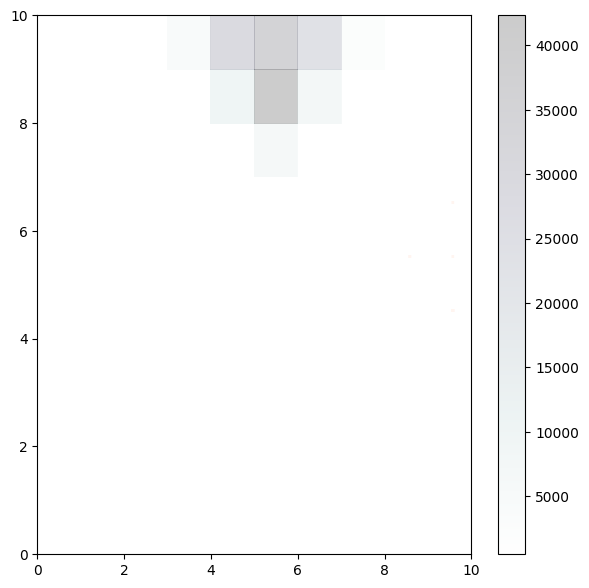

In [12]:
# Инициализация SOM
map_size = (10, 10)  # Размер карты (10x10)
input_size = data.shape[1]
som = SOM(map_size, input_size, sigma=0.3, learning_rate=0.5)

# Обучение SOM
som.train(data, 100)  # Обучение на 100 итераций

# Визуализация результатов
som.visualize(data)